<a href="https://colab.research.google.com/github/pedrolpin4/movies-data-preparation/blob/main/%5BPOC%5D_Match_Categorias_x_Ofertas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Funções**

In [5]:
# !pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00


In [6]:
import torch
import umap
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from numpy import log1p, sqrt, isnan, nan_to_num

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformers import BertTokenizer, BertModel

# Monta o drive
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/Analises pontuais/Categorizacao Catalogo'

Mounted at /content/drive


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Função para pré-processamento dos textos
def preprocess_text(text):
    text = text.lower()  # converter para minúsculo
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])  # remover caracteres especiais
    return text

# Obter melhores categorias baseadas na similaridade
def get_top_categories(similarity_matrix, category_names, offer_names, top_n=4):
    results = []
    for idx, offer_similarities in enumerate(similarity_matrix):
        # Ordenar as categorias por similaridade (da maior para a menor)
        sorted_categories_idx = np.argsort(offer_similarities)[::-1]

        # Pegar as top_n categorias mais similares
        top_categories = [(category_names[i], offer_similarities[i]) for i in sorted_categories_idx[:top_n]]

        # Melhor categoria e seu nível de confiança
        best_match_category, best_match_confidence = top_categories[0]

        # Categorias similares (excluindo a melhor categoria)
        similar_categories = ', '.join([cat[0] for cat in top_categories[1:]])

        # Decidir se deve aplicar baseado no nível de confiança
        apply_decision = 'Sim' if best_match_confidence > 0.9 else ('Dúvida' if best_match_confidence > 0.5 else 'Não')

        # Salvar o resultado para essa oferta
        results.append({
            "Oferta": offer_names[idx],
            "Categoria Melhor Match": best_match_category,
            "Nível de Confiança": best_match_confidence,
            "Categorias Similares": similar_categories,
            "Devo Aplicar": apply_decision
        })

    return results

# Função para encontrar as melhores categorias para cada oferta
def get_top_categories_nobert(oferta_index, top_n=4):
    sim_scores = list(enumerate(cosine_similarities[oferta_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_categories = sim_scores[:top_n]
    return [(categorias_df.iloc[i[0]]['Categorias'], i[1]) for i in top_categories]

# Função para aplicar a decisão de aplicar ou não a categoria
def apply_decision(confidence):
    if confidence > 0.9:
        return "Sim"
    elif confidence > 0.5:
        return "Dúvida"
    else:
        return "Não"

# Função para gerar embeddings
def get_bert_embeddings(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=256)
    with torch.no_grad():
        outputs = model(**encoded_input)
    return outputs.last_hidden_state[:, 0, :].detach()

# **Script**

In [13]:
# Pesos para TF-IDF e BERT
peso_tfidf = 0.7
peso_bert = 0.3

In [15]:
# Carregar os dados das categorias e ofertas
categorias_df = pd.read_csv(f'{path}/categorias-mecanizou.csv')
ofertas_df = pd.read_csv(f'{path}/ofertas-mecanizou.csv')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 332, saw 2


In [ ]:
# Inicialização do tokenizer e do modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

In [ ]:
# 1 - Aplicar o pré-processamento nos dados
categorias_df['Categorias_clean'] = categorias_df['Categorias'].apply(preprocess_text)
ofertas_df['Ofertas_clean'] = ofertas_df['Ofertas'].apply(preprocess_text)


# 2 - Vetorização dos textos com TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix_categorias = vectorizer.fit_transform(categorias_df['Categorias_clean'])
tfidf_matrix_ofertas = vectorizer.transform(ofertas_df['Ofertas_clean'])

# 3 - Calculando a similaridade de cosseno
cosine_similarities = cosine_similarity(tfidf_matrix_ofertas, tfidf_matrix_categorias)

# 4 - Criar DataFrame com os resultados só TfidfVectorizer / cosine_similarity
results = []
for idx, row in ofertas_df.iterrows():
    top_categories = get_top_categories_nobert(idx)
    best_match = top_categories[0]
    should_apply = apply_decision(best_match[1])
    similar_categories = top_categories[1:]

    results.append({
        "Oferta": row['Ofertas'],
        "Categoria Melhor Match": best_match[0],
        "Nível de Confiança": best_match[1],
        "Devo Aplicar": should_apply,
        "Categorias Similares": ', '.join([cat[0] for cat in similar_categories])
    })

result_df = pd.DataFrame(results)

# Contando as ocorrências de cada categoria em 'Devo Aplicar'
counts = result_df['Devo Aplicar'].value_counts()

# Calculando a porcentagem de cada categoria
percentages = counts / counts.sum() * 100

# Criando um novo DataFrame para melhor visualização
summary_df = pd.DataFrame({
    'Devo Aplicar': counts.index,
    'Quantidade': counts.values,
    'Porcentagem (%)': percentages.values
})

# Exibindo o summary_df com a aplicação
print(summary_df)
print('Resultados apenas com TFIDF')
result_df.head(50)

In [ ]:
# 5 - Gerar BERT embeddings
bert_embeddings_categorias = get_bert_embeddings(categorias_df['Categorias_clean'].tolist())
bert_embeddings_ofertas = get_bert_embeddings(ofertas_df['Ofertas_clean'].tolist())

# 6 - Combinação dos embeddings considerando a normalização

# Normalizar os embeddings TF-IDF
scaler_tfidf = StandardScaler()

tfidf_norm_categorias = scaler_tfidf.fit_transform(tfidf_matrix_categorias.toarray())
tfidf_norm_ofertas = scaler_tfidf.transform(tfidf_matrix_ofertas.toarray())

# Normalizar os embeddings BERT
scaler_bert = StandardScaler()
bert_norm_categorias = scaler_bert.fit_transform(bert_embeddings_categorias)
bert_norm_ofertas = scaler_bert.transform(bert_embeddings_ofertas)

# Combinação dos embeddings com pesos ajustáveis
combined_embeddings_categorias = np.hstack([peso_tfidf * tfidf_norm_categorias, peso_bert * bert_norm_categorias])
combined_embeddings_ofertas = np.hstack([peso_tfidf * tfidf_norm_ofertas, peso_bert * bert_norm_ofertas])


#Sem normalizar
#combined_embeddings_categorias = np.hstack([tfidf_matrix_categorias.toarray(), bert_embeddings_categorias])
#combined_embeddings_ofertas = np.hstack([tfidf_matrix_ofertas.toarray(), bert_embeddings_ofertas])

# 7 - Aplicar logaritmo (log1p é usado para evitar problemas com valores zero)
combined_embeddings_categorias_log = log1p(combined_embeddings_categorias)
combined_embeddings_ofertas_log = log1p(combined_embeddings_ofertas)

# Substituir NaN por 0 (ou outro valor numérico que faça sentido no contexto)
combined_embeddings_categorias_log = nan_to_num(combined_embeddings_categorias_log, nan=0.0)
combined_embeddings_ofertas_log = nan_to_num(combined_embeddings_ofertas_log, nan=0.0)

# 8 - Calcular similaridade de cosseno
cosine_similarities = cosine_similarity(combined_embeddings_ofertas, combined_embeddings_categorias)

# 9 - Criar DataFrame com cosine_similarity com os resultados de TfidfVectorizer + BERT :
results = get_top_categories(cosine_similarities, categorias_df['Categorias'].tolist(), ofertas_df['Ofertas'].tolist())
results_df = pd.DataFrame(results)


# Contando as ocorrências de cada categoria em 'Devo Aplicar'
counts = result_df['Devo Aplicar'].value_counts()

# Calculando a porcentagem de cada categoria
percentages = counts / counts.sum() * 100

# Criando um novo DataFrame para melhor visualização
summary_df = pd.DataFrame({
    'Devo Aplicar': counts.index,
    'Quantidade': counts.values,
    'Porcentagem (%)': percentages.values
})

# Exibindo o summary_df com a aplicação
print(summary_df)
print('Resultados apenas com TFIDF + BERT')
result_df.head(50)



print('Resultados mescalndo BertModel + TfidfVectorizer')
results_df.head(50)

# **Plotando os resultados para entender a dispersão**

Plotando resultados usando PCA...


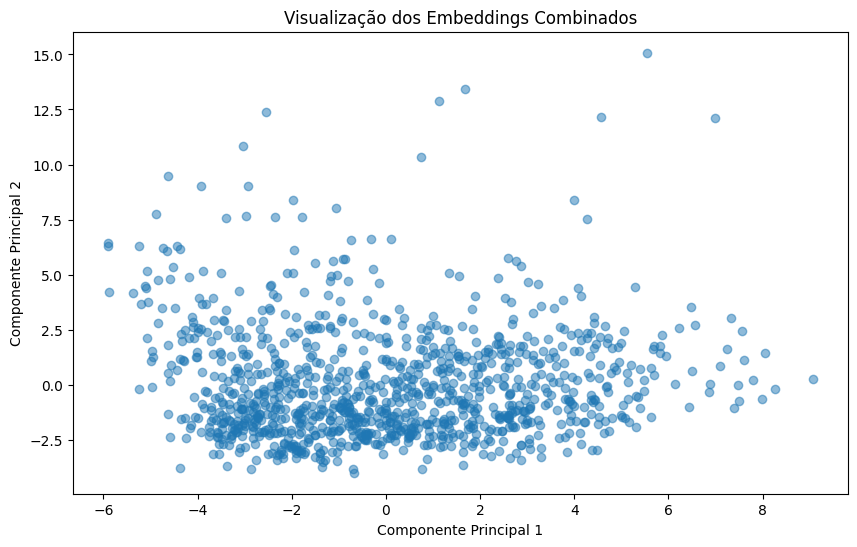

Plotando resultados usando t-SNE...


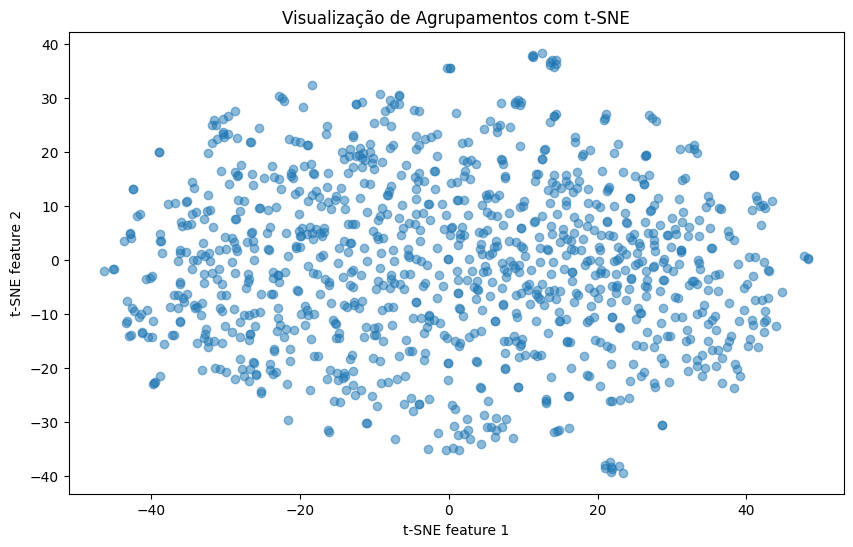

In [ ]:
# Plotando os resultados do PCA
print('Plotando resultados usando PCA...')
pca = PCA(n_components=2)
combined_reduced = pca.fit_transform(combined_embeddings_categorias)

plt.figure(figsize=(10, 6))
plt.scatter(combined_reduced[:, 0], combined_reduced[:, 1], alpha=0.5)
plt.title('Visualização dos Embeddings Combinados')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()




Plotando resultados usando t-SNE...


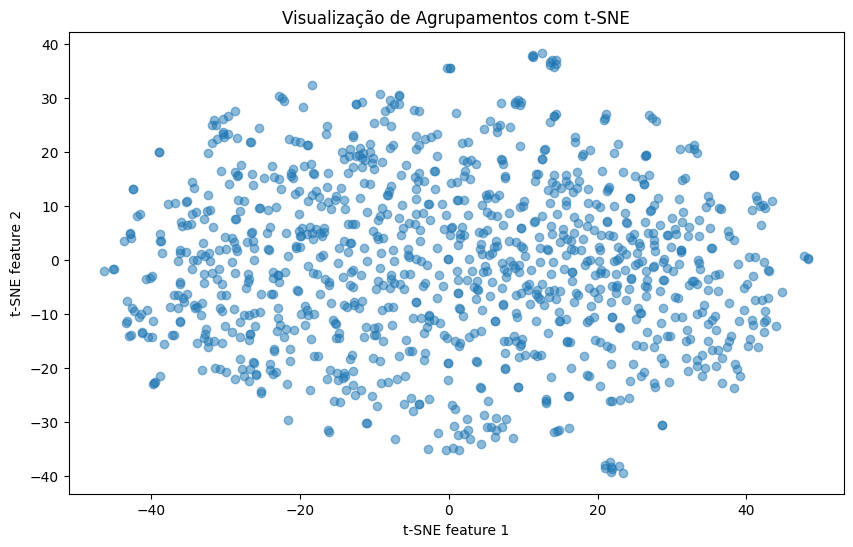

In [ ]:
# Plotando os resultados do t-SNE
print('Plotando resultados usando t-SNE...')
tsne = TSNE(n_components=2, random_state=1000)  # n_components=2 para 2D
tsne_results = tsne.fit_transform(combined_embeddings_categorias_log)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('Visualização de Agrupamentos com t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

Plotando resultados usando UMAP...


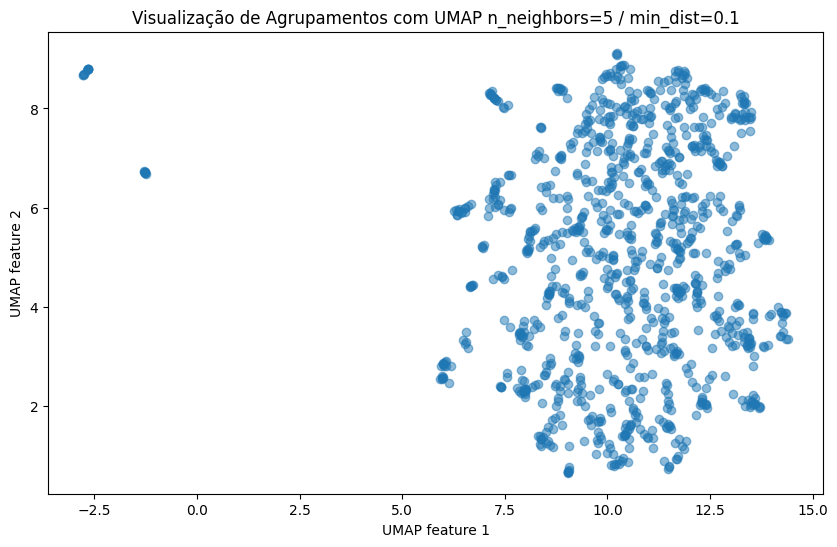

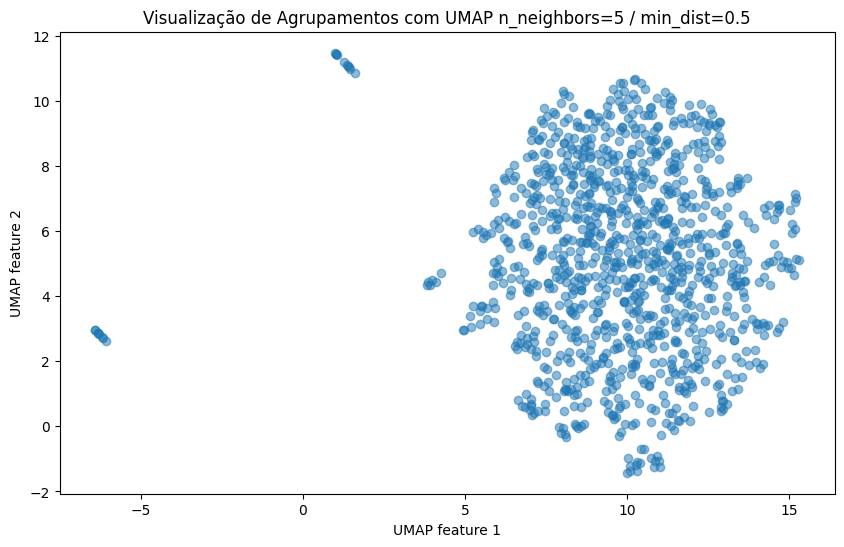

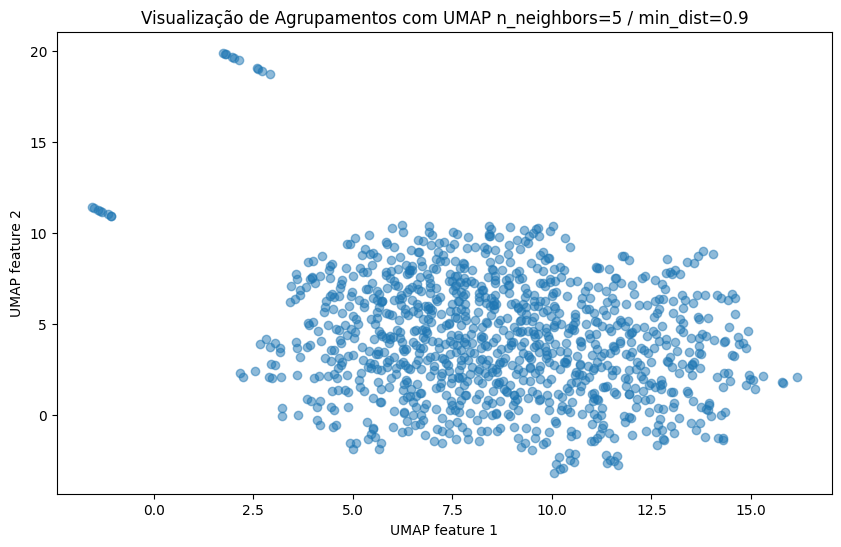

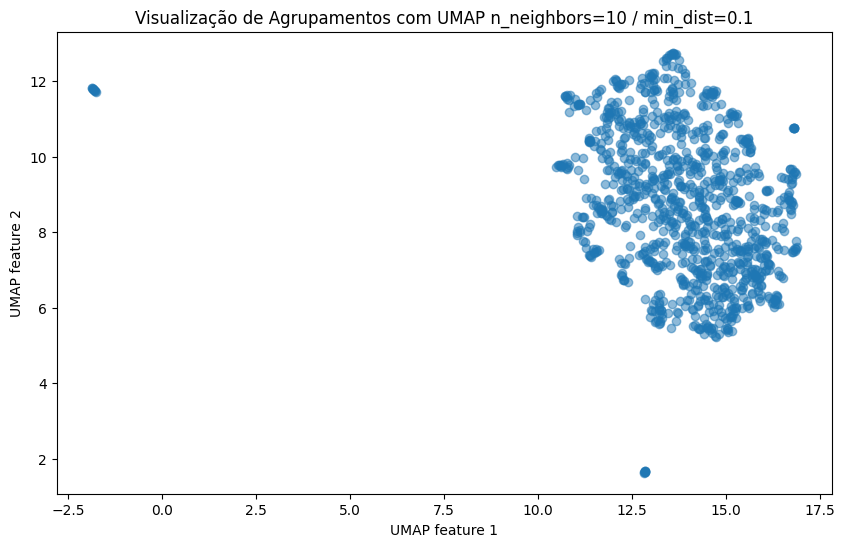

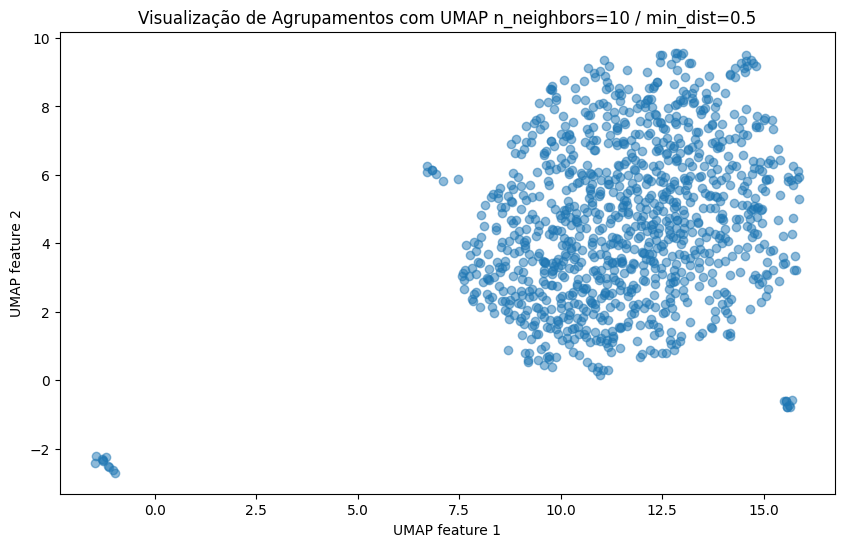

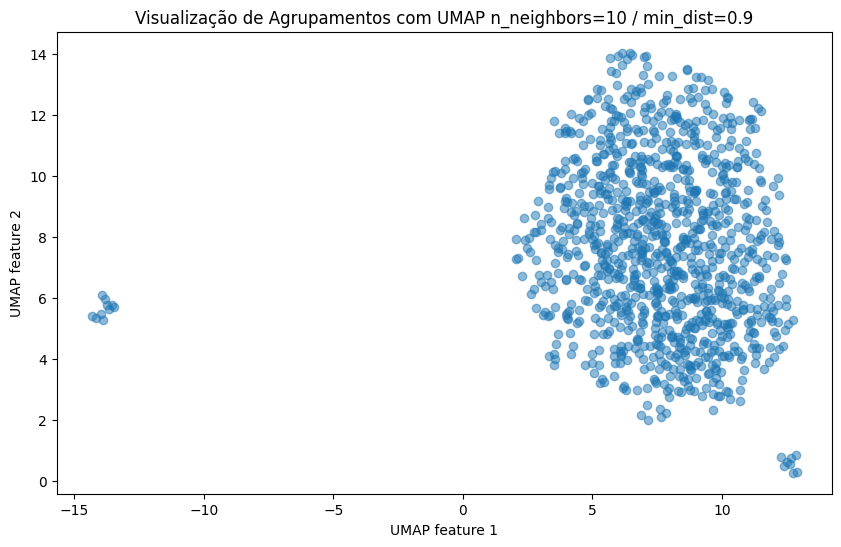

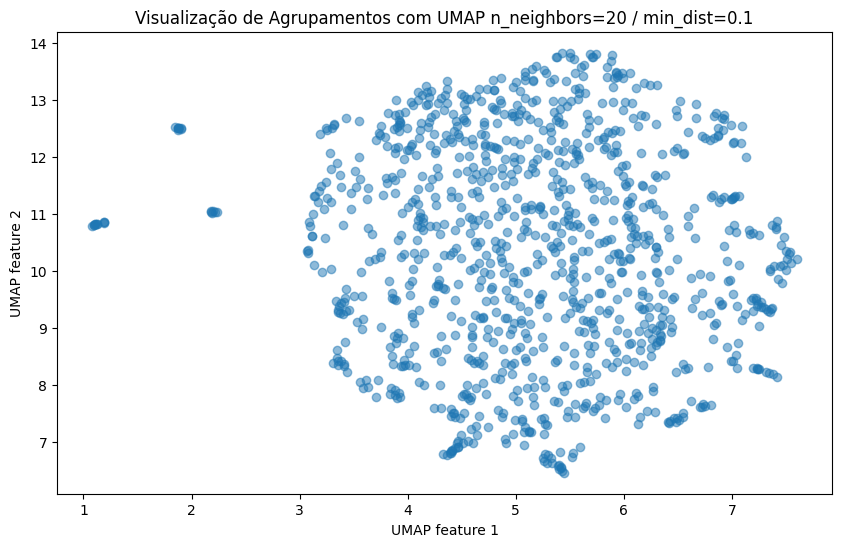

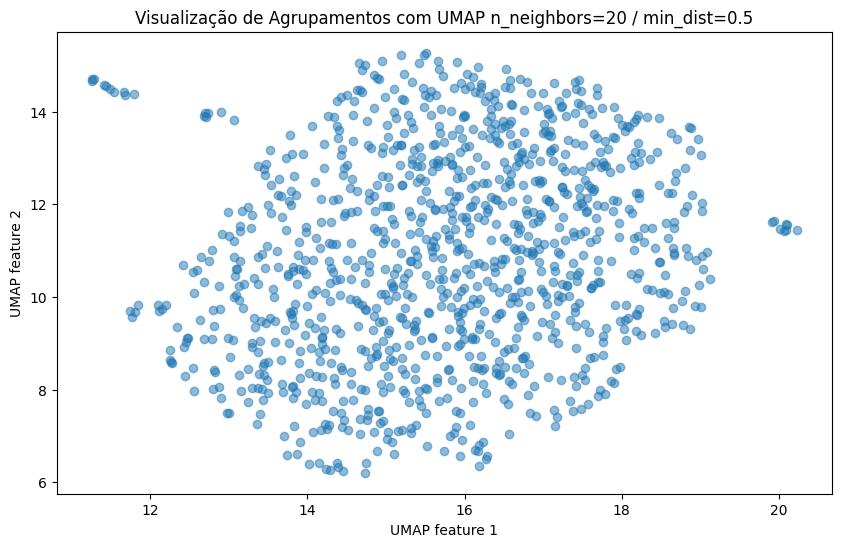

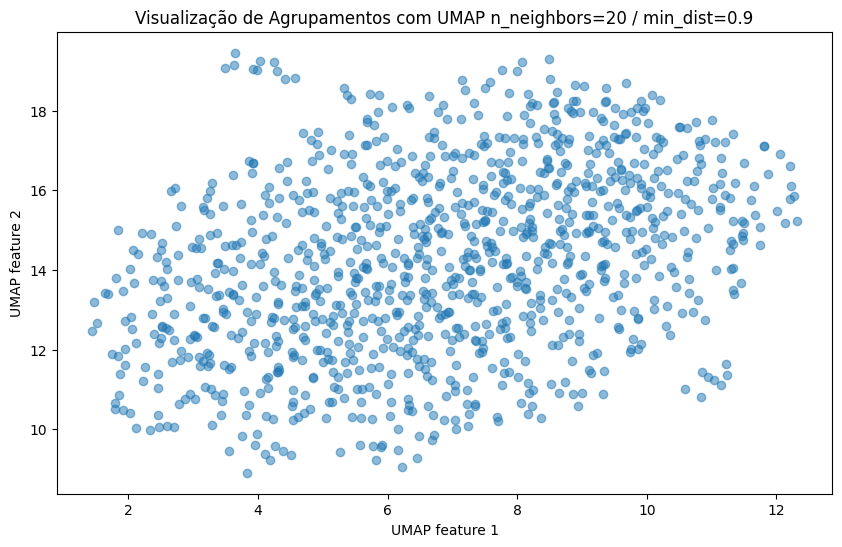

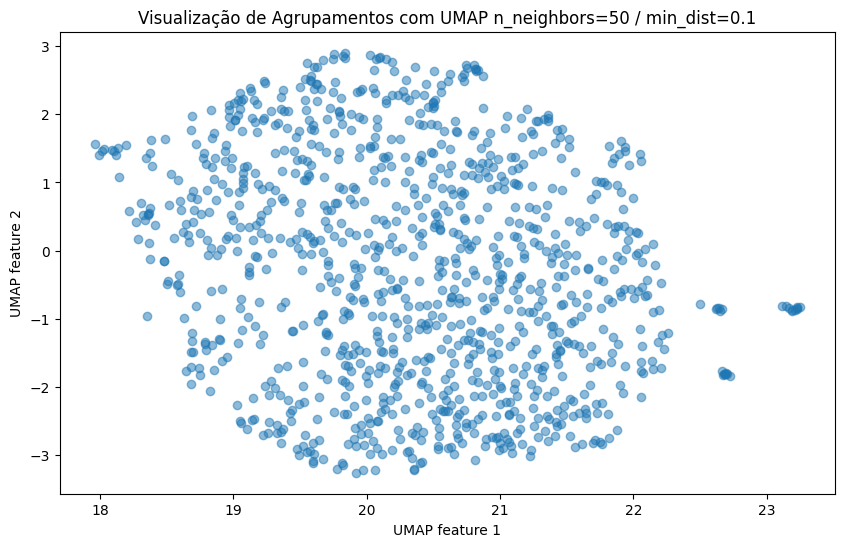

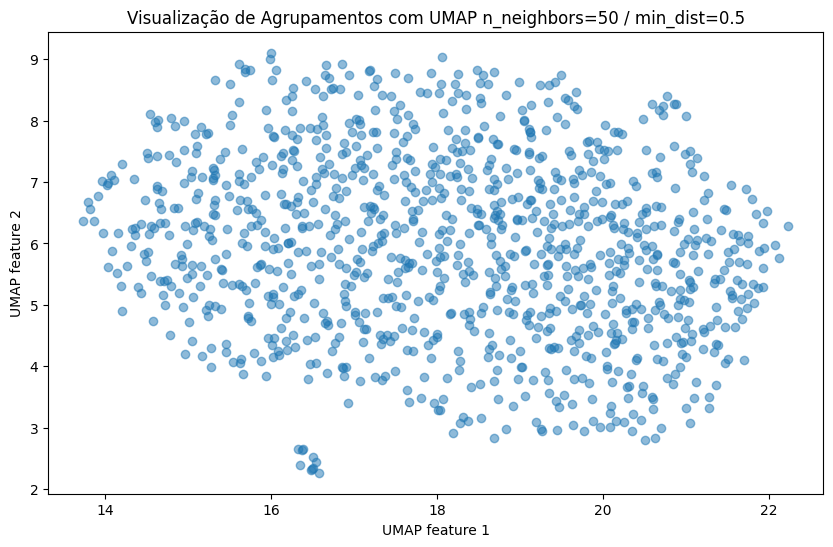

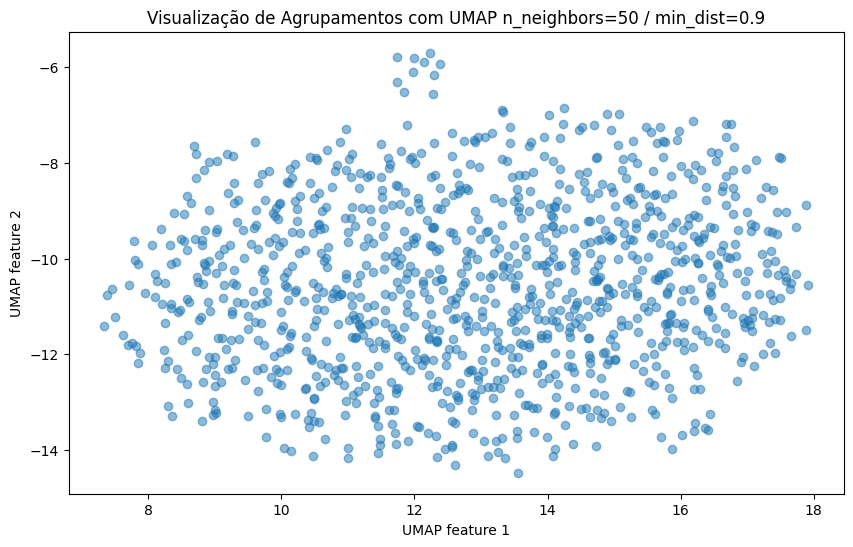

In [ ]:
print('Plotando resultados usando UMAP...')
# Criando varias configurações vizinhos e distancia
for n in [5, 10, 20, 50]:
    for d in [0.1, 0.5, 0.9]:
        reducer = umap.UMAP(n_neighbors=n, min_dist=d, metric='euclidean')
        results = reducer.fit_transform(combined_embeddings_categorias_log)

        # Plotando os resultados do UMAP
        plt.figure(figsize=(10, 6))
        plt.scatter(results[:, 0], results[:, 1], alpha=0.5)
        plt.title(f'Visualização de Agrupamentos com UMAP n_neighbors={n} / min_dist={d}')
        plt.xlabel('UMAP feature 1')
        plt.ylabel('UMAP feature 2')
        plt.show()